The proportion of countries per community is  0:47.6%, 1:37.2%, and 2:15.2%. I wasn't sure whether this may affect the results found or is not relevant. To make sure that the result is independent of the relative proportions of countries among the communities found, I believe that one valid option could be to randomly generate labels of three categorical classes to simulate the three communities found and assign a different probability of occurrence of the simulated labels among countries using the original proportion of countries per community. Here I performed this test and found that randomly assigning labels does not yield the same patterns found by using the community detection algorithms.  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [19]:
af_ex_pr = pd.read_csv('antifragilidades_datasets/af.csv')
af_ex_pr = af_ex_pr.rename(columns={'Unnamed: 0':'country','Unnamed: 1':'year'})
af_ex_pr = af_ex_pr.iloc[:,[0,1,4]]

In [20]:
pivot_afex=af_ex_pr.pivot_table(values='af_ex_pr',columns='country',index='year')
pivot_afex=pivot_afex.drop(columns='Unspecified Area')
pivot_afex=pivot_afex.dropna(thresh=10,axis=1)
pivot_afex = pivot_afex.interpolate(limit_direction='both',method='spline',order=1)

In [22]:
pop=pd.read_csv('pairing_data/Population_clean.csv',index_col=0)
gdp = pd.read_csv('pairing_data/GDP_clean.csv',index_col=0)
distance = pd.read_csv('pairing_data/for_distance_pairing/distances_year_ex_im.csv',index_col=0) # distances in Km
df_communities = pd.read_csv('community_countries.csv',index_col=0)

In [75]:
df_communities['labels'] = np.random.choice([0,1,2,3,4],size=df_communities.shape[0],p=[0.3, 0.28823529, 0.24117647, 0.16470588, 0.00588235])
mergd_afex_communities = pivot_afex.T.merge(df_communities,on='country')    

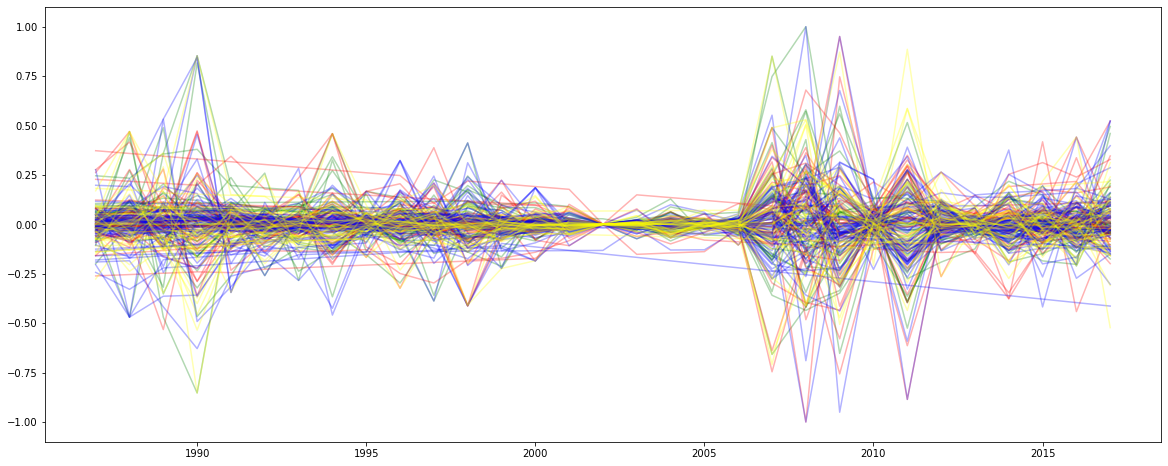

In [76]:
fig,ax=plt.subplots(figsize=(20,8))
for i,color in zip(df_communities['labels'].unique(),['green','red','blue','yellow']):
    mergd_afex_communities[mergd_afex_communities['labels']==i].T.drop(['country','labels']).plot(legend=False,c=color,alpha=0.3,ax=ax)

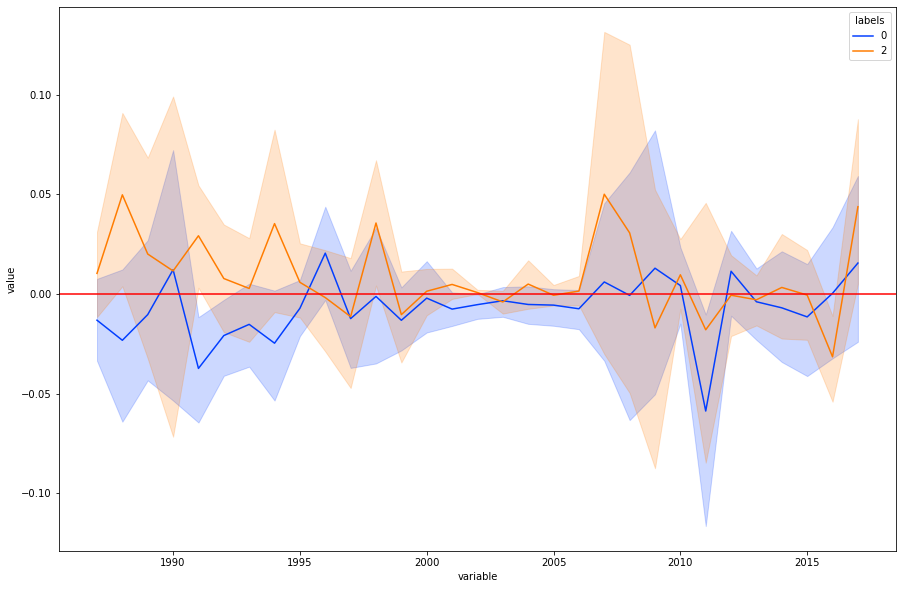

In [77]:
_=mergd_afex_communities.melt(id_vars=['country','labels'])

plt.figure(figsize=(15,10))
sns.lineplot(data=_[np.isin(_['labels'],[0,2])],x='variable',y='value',hue='labels',palette='bright')
plt.axhline(0,c='red')

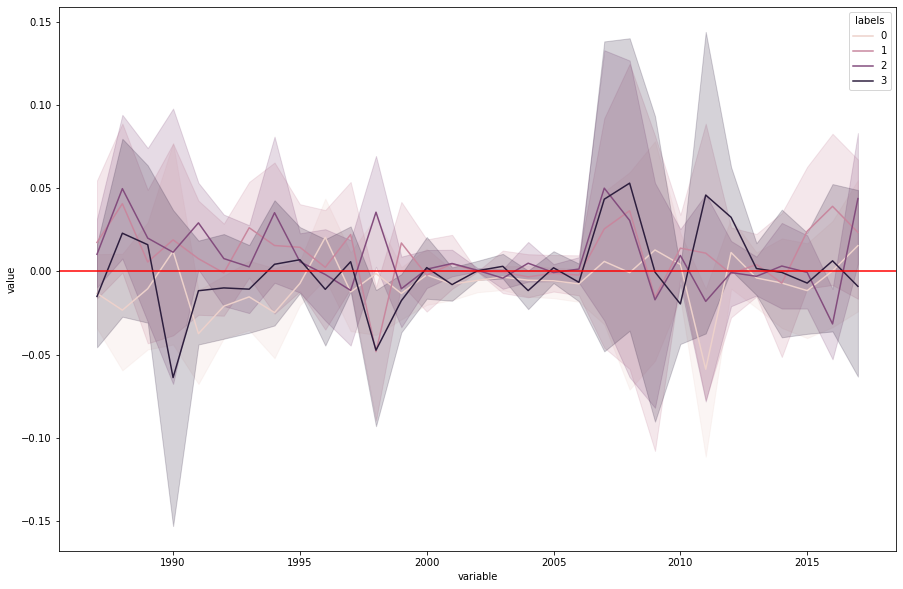

In [78]:
plt.figure(figsize=(15,10))
sns.lineplot(data=mergd_afex_communities.melt(id_vars=['country','labels']),x='variable',y='value',hue='labels')
plt.axhline(0,c='red')

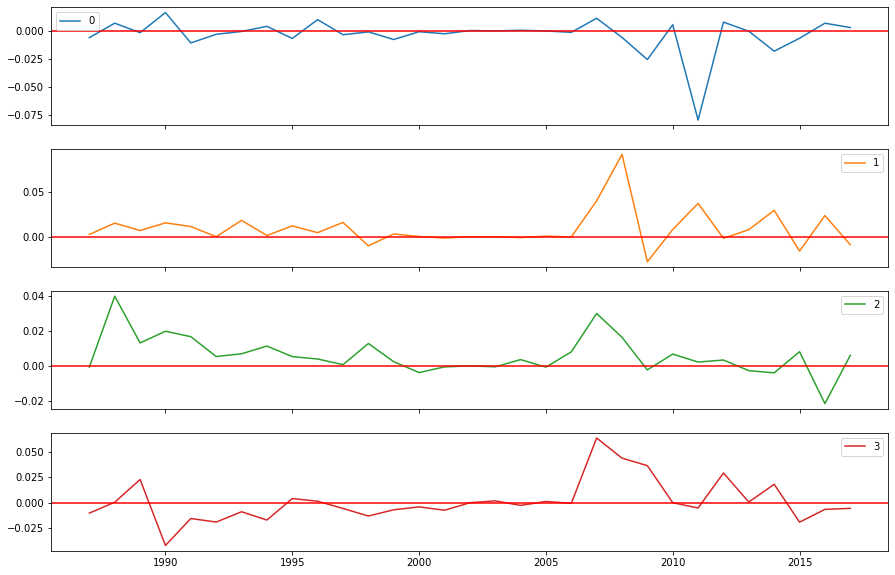

In [79]:
ax=mergd_afex_communities.groupby('labels').median().T.plot(subplots=True,figsize=(15,10))
for axi in ax: 
    axi.axhline(0,c='red')

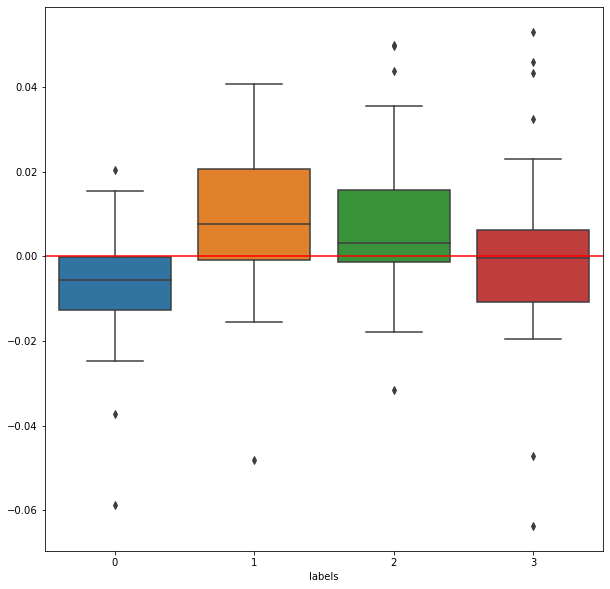

In [80]:
fig,axs=plt.subplots(1,1,figsize=(10,10))

sns.boxplot(data=mergd_afex_communities.groupby('labels').mean().T,ax=axs)
_=axs.axhline(0,c='red')

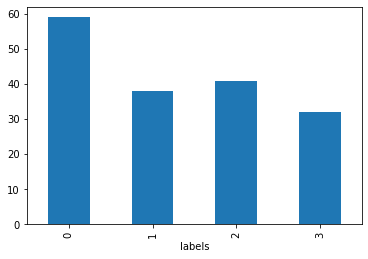

In [81]:
_=(mergd_afex_communities.groupby('labels').count()['country']).plot.bar() # Number of countries per community

In [82]:
merged_pop_communities = pop.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_gdp_communities = gdp.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_pop_communities = merged_pop_communities[['date','value','country','labels']]
merged_gdp_communities = merged_gdp_communities[['date','value','country','labels']]

merged_distances_ex_communities = distance.groupby(['exporter','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns='exporter',axis=1)
merged_distances_in_communities = distance.groupby(['importer','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns='importer',axis=1)

Text(0.5, 1.0, 'Population')

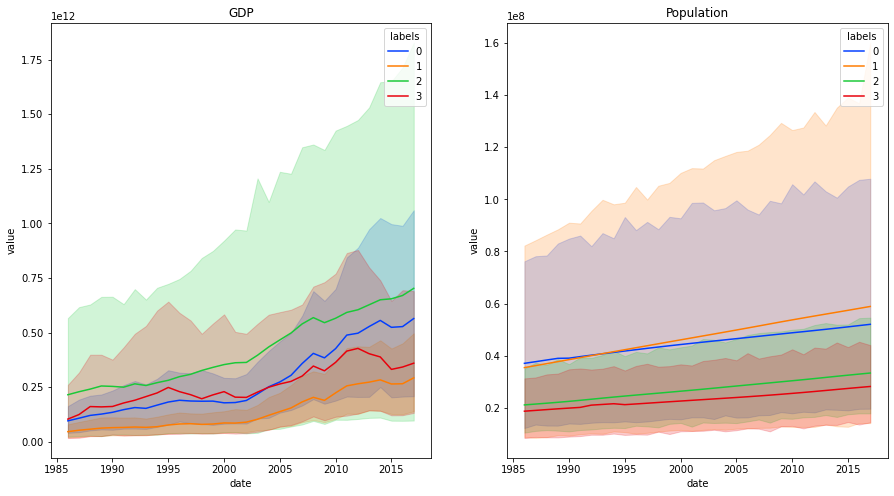

In [83]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
a=sns.lineplot(data=merged_gdp_communities,y='value',x='date',hue='labels',ax=axs[0],palette='bright')
b=sns.lineplot(data=merged_pop_communities[['date','value','country','labels']],y='value',x='date',hue='labels',ax=axs[1],palette='bright')
axs[0].set_title('GDP')
axs[1].set_title('Population')

In [84]:
parametric_plot=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index().merge(
    mergd_afex_communities.groupby('labels').mean().T.reset_index().melt(id_vars='index',value_name='antifragility').rename({'index':'Year'},axis=1),on=['Year','labels'])

Text(0.5, 0, 'exportation distances')

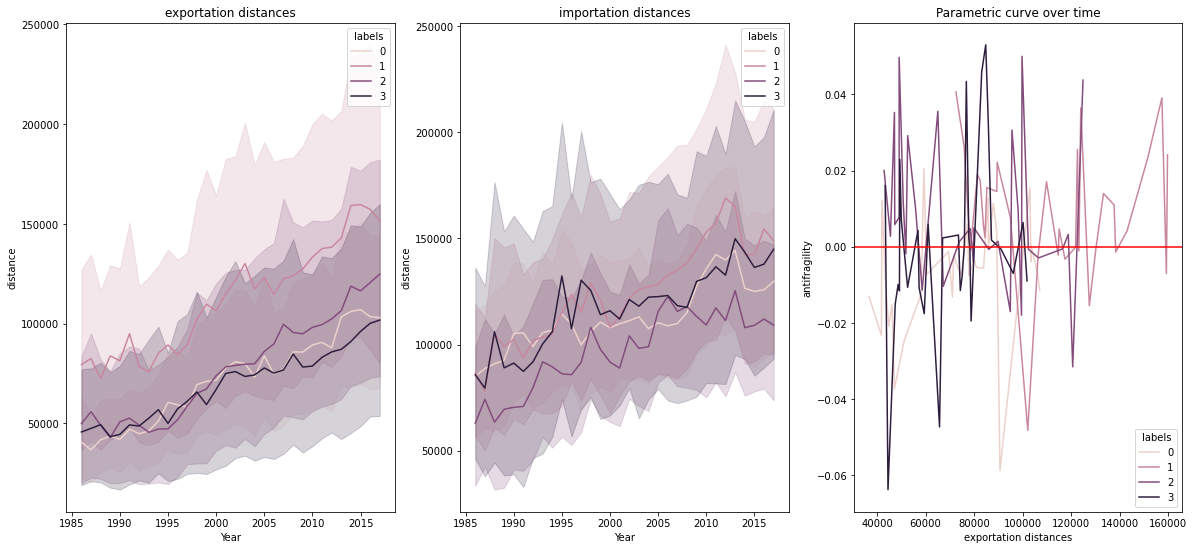

In [85]:
fig,axs=plt.subplots(1,3,figsize=(20,9)) # 2.8
sns.lineplot(data=merged_distances_ex_communities,y='distance',x='Year',hue='labels',hue_order=df_communities['labels'].unique(),ax=axs[0])
sns.lineplot(data=merged_distances_in_communities,y='distance',x='Year',hue='labels',hue_order=df_communities['labels'].unique(),ax=axs[1])
sns.lineplot(data=parametric_plot,x='distance',y='antifragility',hue='labels')
axs[2].axhline(0,c='red')
axs[0].set_title('exportation distances')
axs[1].set_title('importation distances')
axs[2].set_title('Parametric curve over time')
axs[2].set_xlabel('exportation distances')

In [86]:
numbers_exporters = distance.groupby(['exporter','Year']).count().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns=['exporter','distance'],axis=1).rename({'importer':'# of countries'},axis=1)
numbers_importers = distance.groupby(['importer','Year']).count().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns=['importer','distance'],axis=1).rename({'exporter':'# of countries'},axis=1)

In [87]:
parametric_plot_numbers=numbers_exporters.groupby(['Year','labels']).mean().reset_index().merge(
    mergd_afex_communities.groupby('labels').mean().T.reset_index().melt(id_vars='index',value_name='antifragility').rename({'index':'Year'},axis=1),on=['Year','labels'])

Text(0.5, 1.0, 'Parametric plot')

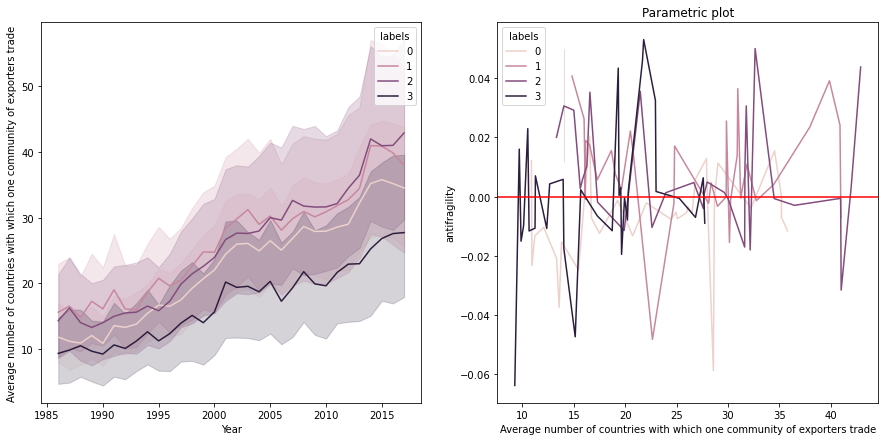

In [88]:
fig,axs=plt.subplots(1,2,figsize=(15,7)) 
sns.lineplot(data=numbers_exporters,y='# of countries',x='Year',hue='labels',hue_order=df_communities['labels'].unique(),ax=axs[0])
# sns.lineplot(data=numbers_importers,y='# of countries',x='Year',hue='labels',hue_order=df_communities['labels'].unique(),ax=axs[1])
sns.lineplot(data=parametric_plot_numbers,x='# of countries',y='antifragility',hue='labels',ax=axs[1])
axs[1].axhline(0,c='red')
# axs[1].set_ylabel('Average number of countries with which one community of importers trade')
axs[1].set_xlabel('Average number of countries with which one community of exporters trade')
axs[0].set_ylabel('Average number of countries with which one community of exporters trade')
axs[1].set_title('Parametric plot')